<a href="https://colab.research.google.com/github/zainnabtarrek/Computer-Vision/blob/main/Bees_vs_Ants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class.

download data from https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()


In [ ]:
print(torch.cuda.is_available())
print(torch.__version__)

True
2.3.0+cu121


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

data_folder = '/content/drive/My Drive/hymenoptera_data'
print(os.listdir(data_folder))


['train', 'val']


In [ ]:
train='/content/drive/My Drive/hymenoptera_data/train'
val='/content/drive/My Drive/hymenoptera_data/val'
print(os.listdir(train))

['bees', 'ants']


This is a very small dataset to generalize upon,

since we will first train from scratch, we have to do some augmentation

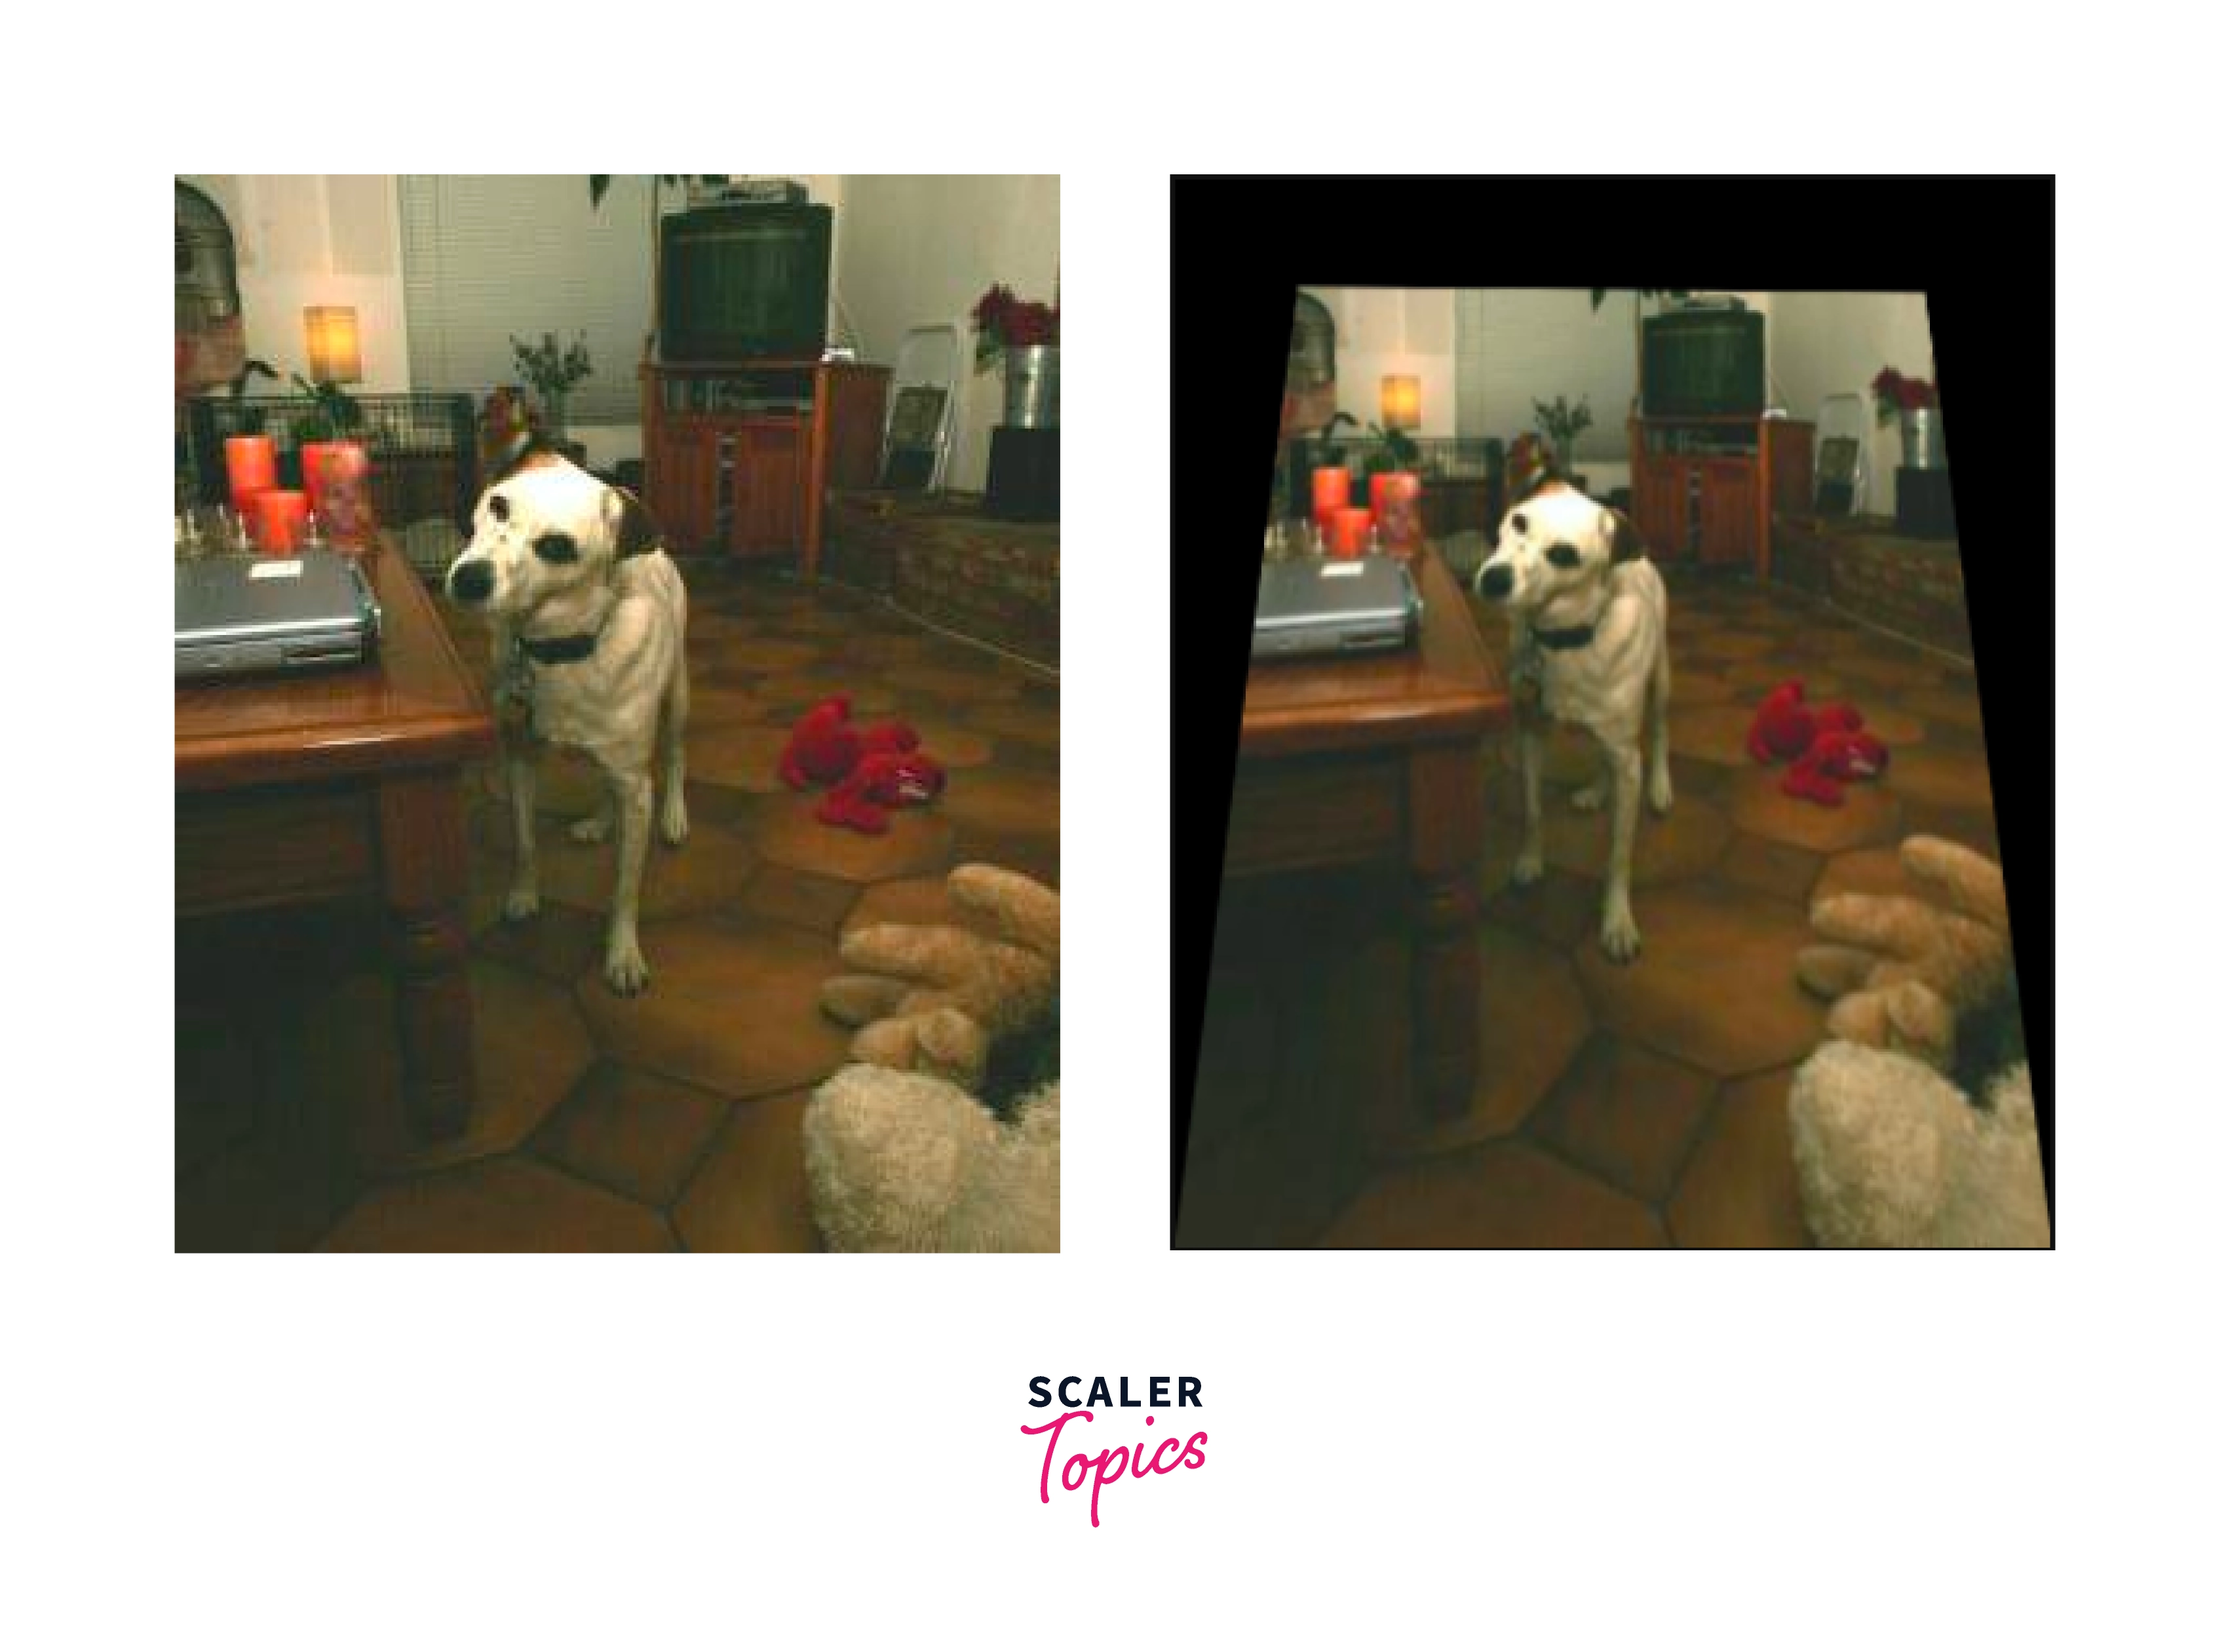

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=30),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_folder, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
train_data= {x: datasets.ImageFolder(os.path.join(data_folder, x),
                                          data_transforms[x])
                  for x in ['train']}
val_data = {x: datasets.ImageFolder(os.path.join(data_folder, x),
                                          data_transforms[x])
                  for x in ['val']}
train_loader={x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train']}
val_loader={x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['val']}

In [ ]:
print(dataset_sizes)


{'train': 244, 'val': 153}


#CNN from scratch

In [ ]:
import torch
import torch.nn as nn

class BinaryImageClassification(nn.Module):
    def __init__(self):
        super(BinaryImageClassification, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.fc_block = nn.Sequential(
            nn.Linear(128 * 224 * 224, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 2)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view( -1,128 * 224 * 224)  # Flatten
        x = self.fc_block(x)
        return x


model = BinaryImageClassification()
print(model)


BinaryImageClassification(
  (conv_block): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (fc_block): Sequential(
    (0): Linear(in_features=6422528, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=2, bias=True)
  )
)


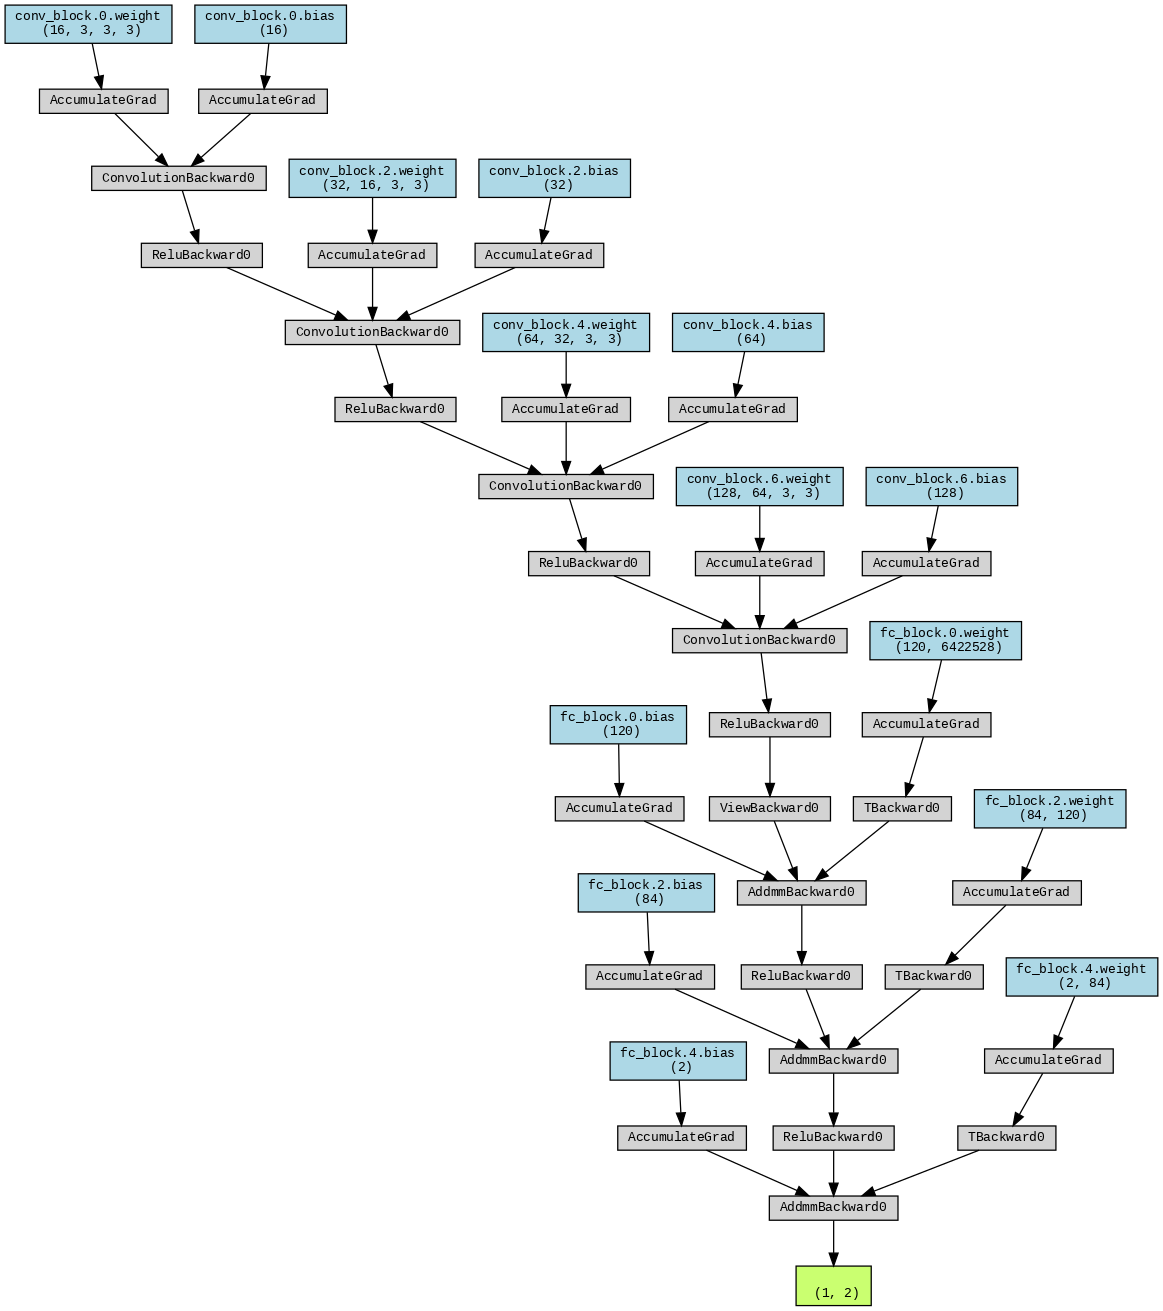

In [ ]:
!pip install torchviz
from torchviz import make_dot


model = BinaryImageClassification()

input_tensor = torch.randn(1, 3, 224, 224)


dot = make_dot(model(input_tensor), params=dict(model.named_parameters()))


dot.render("model", format="png")


from IPython.display import Image
Image(filename="model.png")


In [ ]:
model = BinaryImageClassification().to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


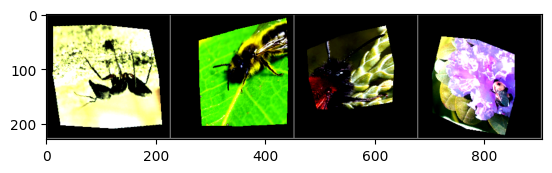

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


for loader in train_loader.values():
    dataiter = iter(loader)
    images, labels = next(dataiter)


    imshow(torchvision.utils.make_grid(images))
    break

In [ ]:
print(images.shape)
print(labels.shape)

torch.Size([4, 3, 224, 224])
torch.Size([4])


In [ ]:
n_total_steps = len(train_loader['train'])
for epoch in range(50):
    for i, (inputs, labels) in enumerate(train_loader['train']):

        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        print (f'Epoch [{epoch+1}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

Epoch [1], Step [1/61], Loss: 0.6550
Epoch [1], Step [2/61], Loss: 0.6971
Epoch [1], Step [3/61], Loss: 0.6466
Epoch [1], Step [4/61], Loss: 0.6444
Epoch [1], Step [5/61], Loss: 0.7015
Epoch [1], Step [6/61], Loss: 0.7640
Epoch [1], Step [7/61], Loss: 0.7519
Epoch [1], Step [8/61], Loss: 0.6535
Epoch [1], Step [9/61], Loss: 0.7454
Epoch [1], Step [10/61], Loss: 0.6970
Epoch [1], Step [11/61], Loss: 0.6533
Epoch [1], Step [12/61], Loss: 0.6018
Epoch [1], Step [13/61], Loss: 0.6444
Epoch [1], Step [14/61], Loss: 0.7004
Epoch [1], Step [15/61], Loss: 0.6434
Epoch [1], Step [16/61], Loss: 0.5826
Epoch [1], Step [17/61], Loss: 0.5745
Epoch [1], Step [18/61], Loss: 0.7017
Epoch [1], Step [19/61], Loss: 0.7028
Epoch [1], Step [20/61], Loss: 0.7023
Epoch [1], Step [21/61], Loss: 0.7023
Epoch [1], Step [22/61], Loss: 0.6372
Epoch [1], Step [23/61], Loss: 0.7699
Epoch [1], Step [24/61], Loss: 0.7009
Epoch [1], Step [25/61], Loss: 0.7614
Epoch [1], Step [26/61], Loss: 0.6995
Epoch [1], Step [27/6

In [ ]:
classes = ('bees', 'ants')
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in val_loader['val']:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()


        for i in range(labels.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')


    for i in range(len(classes)):
        if n_class_samples[i] != 0:  # Handle potential zero division
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {classes[i]}: {acc} %')
        else:
            print(f'No samples for class {classes[i]} found.')

Accuracy of the network: 54.248366013071895 %
Accuracy of bees: 85.71428571428571 %
Accuracy of ants: 27.710843373493976 %


#Using a pretrained model

In [ ]:
!pip install torchvision
from torchvision.models import resnet18, ResNet18_Weights
weights=ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
transforms = weights.transforms()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


In [ ]:
from PIL import Image
image = Image.open("/content/drive/My Drive/hymenoptera_data/val/ants/800px-Meat_eater_ant_qeen_excavating_hole.jpg")
image_tensor = transforms(image)
image_reshaped = image_tensor.unsqueeze(0)

In [ ]:
model.eval()
with torch.no_grad():
  pred = model(image_reshaped).squeeze(0)
pred_cls = pred.softmax(0)
cls_id = pred_cls.argmax().item()
cls_name = weights.meta["categories"][cls_id]
print(cls_name)



ant


In [ ]:

model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model = model.to(device)
n_total_steps = len(train_loader['train'])
for epoch in range(50):
    for i, (images, labels) in enumerate(train_loader['train']):

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        print (f'Epoch [{epoch+1}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './finetuned_resnet.pth'
torch.save(model.state_dict(), PATH)
classes = ('bees', 'ants')

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in val_loader['val']:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()


        for i in range(labels.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')


    for i in range(len(classes)):
        if n_class_samples[i] != 0:  # Handle potential zero division
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Accuracy of {classes[i]}: {acc} %')
        else:
            print(f'No samples for class {classes[i]} found.')


Epoch [1], Step [1/61], Loss: 0.7300
Epoch [1], Step [2/61], Loss: 0.7188
Epoch [1], Step [3/61], Loss: 0.5565
Epoch [1], Step [4/61], Loss: 0.8554
Epoch [1], Step [5/61], Loss: 0.6657
Epoch [1], Step [6/61], Loss: 0.5095
Epoch [1], Step [7/61], Loss: 0.9109
Epoch [1], Step [8/61], Loss: 0.4872
Epoch [1], Step [9/61], Loss: 0.6505
Epoch [1], Step [10/61], Loss: 1.0784
Epoch [1], Step [11/61], Loss: 1.2184
Epoch [1], Step [12/61], Loss: 0.6022
Epoch [1], Step [13/61], Loss: 0.8962
Epoch [1], Step [14/61], Loss: 0.9052
Epoch [1], Step [15/61], Loss: 0.5066
Epoch [1], Step [16/61], Loss: 0.7235
Epoch [1], Step [17/61], Loss: 0.5833
Epoch [1], Step [18/61], Loss: 0.3126
Epoch [1], Step [19/61], Loss: 0.4291
Epoch [1], Step [20/61], Loss: 0.4223
Epoch [1], Step [21/61], Loss: 0.5340
Epoch [1], Step [22/61], Loss: 0.3203
Epoch [1], Step [23/61], Loss: 0.5367
Epoch [1], Step [24/61], Loss: 0.7534
Epoch [1], Step [25/61], Loss: 0.6385
Epoch [1], Step [26/61], Loss: 0.6795
Epoch [1], Step [27/6